In [1]:
import warnings;
warnings.filterwarnings('ignore')

In [3]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
sns.set_context('poster',font_scale=1.4)
import pandas as pd
import pyccl as ccl
from itertools import chain
from pprint import pprint
from math import fsum


Populating the interactive namespace from numpy and matplotlib


In [12]:
ccl.__version__ == '0.10.dev180+g20f8b0fb'

True

# Creating Photo-z Distributions

## Source galaxy distribution

### Creating 5 bins with equal number of source galaxies

source sample: 5 redshift bins defined with equal numbers of source galaxies per bins

In [13]:
# getting the n(z) distribution from the LSSTDESC/Requirements github repo for Y10 and i+r bands. 
# only using this for source galaxy binning.

df = pd.read_csv('nzdist.txt', sep=' ') 
df.head()

,zmid,dn,dneff
0,0.05,0.107288,0.101795
1,0.15,0.600815,0.497371
2,0.25,1.233816,0.946778
3,0.35,2.521276,1.889779
4,0.45,3.350079,2.331543


In [14]:
zmid = df['zmid']
dneff = df['dneff']

# turn zmid, dneff pairs into a histogrammable dataset.
datapts = ([list(np.ones(int(dneff[i]/min(dneff)))*zmid[i]) for i in range(len(zmid))])
datapts = list(chain.from_iterable(datapts)) # flatten

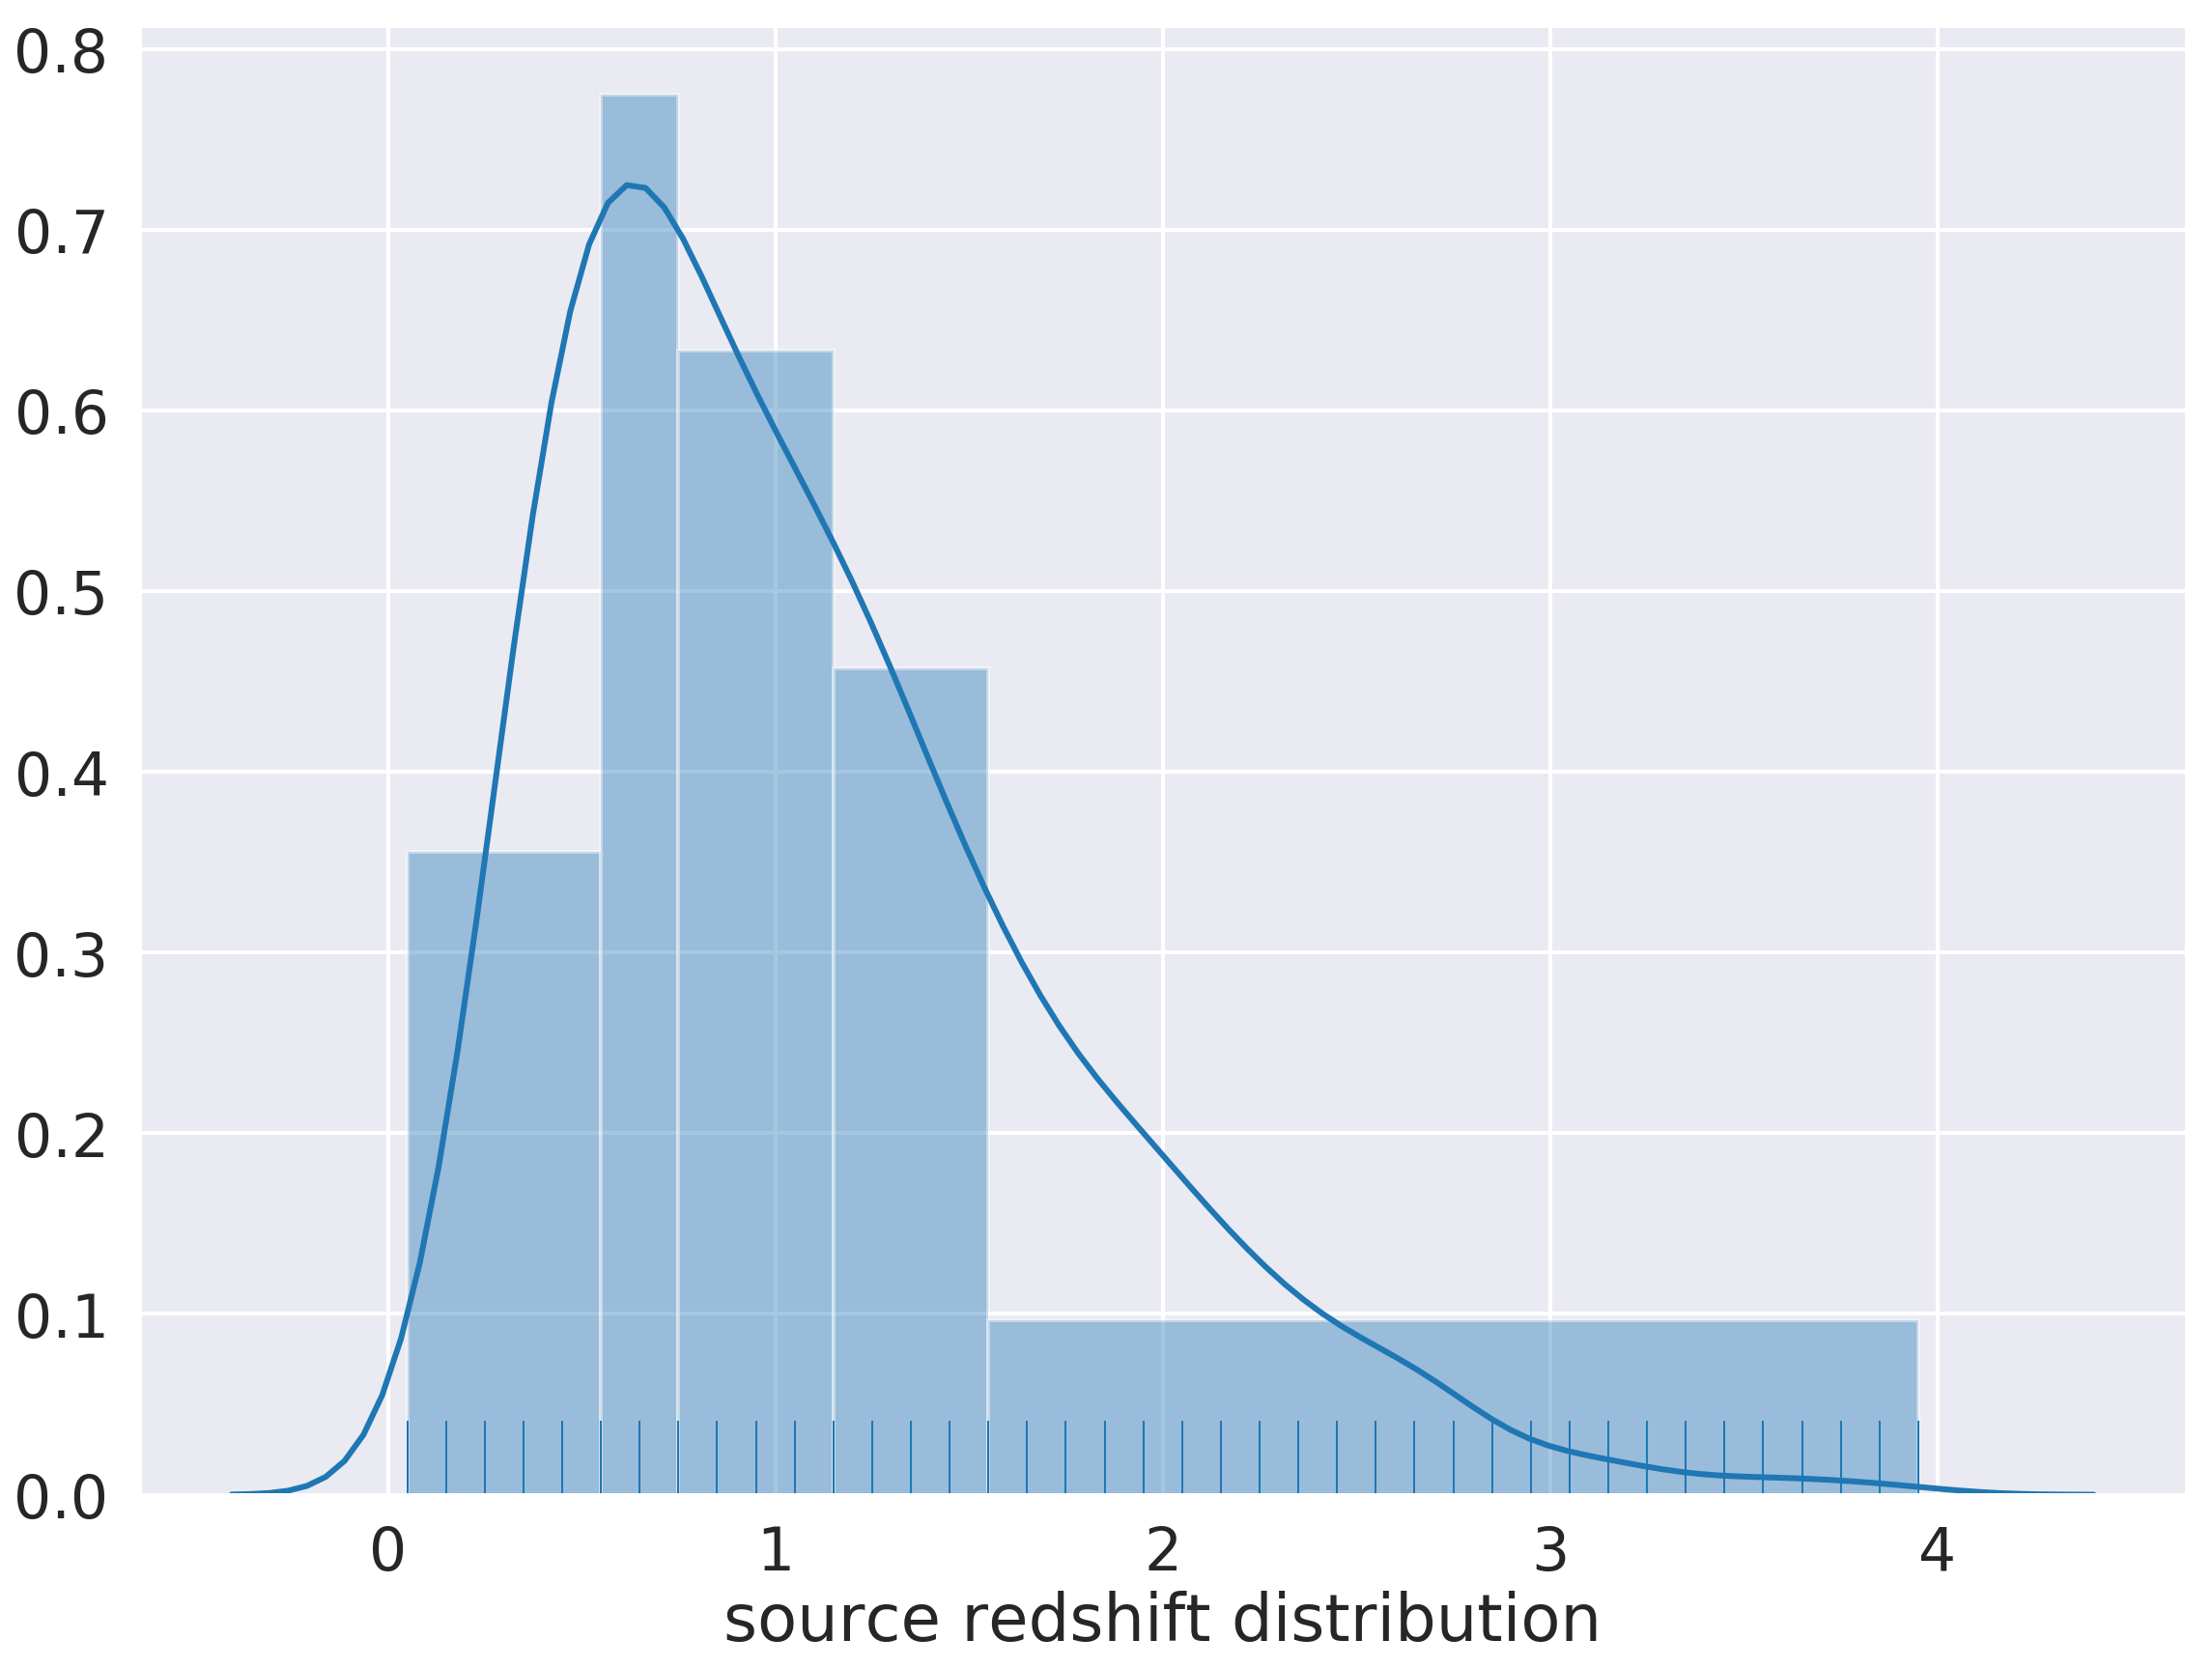

In [15]:
bins = datapts[0::int(len(datapts)/5)] # bin edges
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('source redshift distribution');

In [16]:
bin_centers = [.5*fsum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]

### Create source dN/dz distribution

In [17]:
def photoz(z_ph, z_s, args=None):
    # sigma_z = 0.05*(1+z)
    return z_ph
    # return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
    #       * 1/np.sqrt(2*np.pi*sigma_z**2)

In [18]:
pz = ccl.PhotoZFunction(photoz)

In [19]:
z = np.linspace(0, 4, 121)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

In [20]:
dNdz_dict_source.keys()

dict_keys([0.30000000000000004, 0.65, 0.95, 1.35, 2.75])

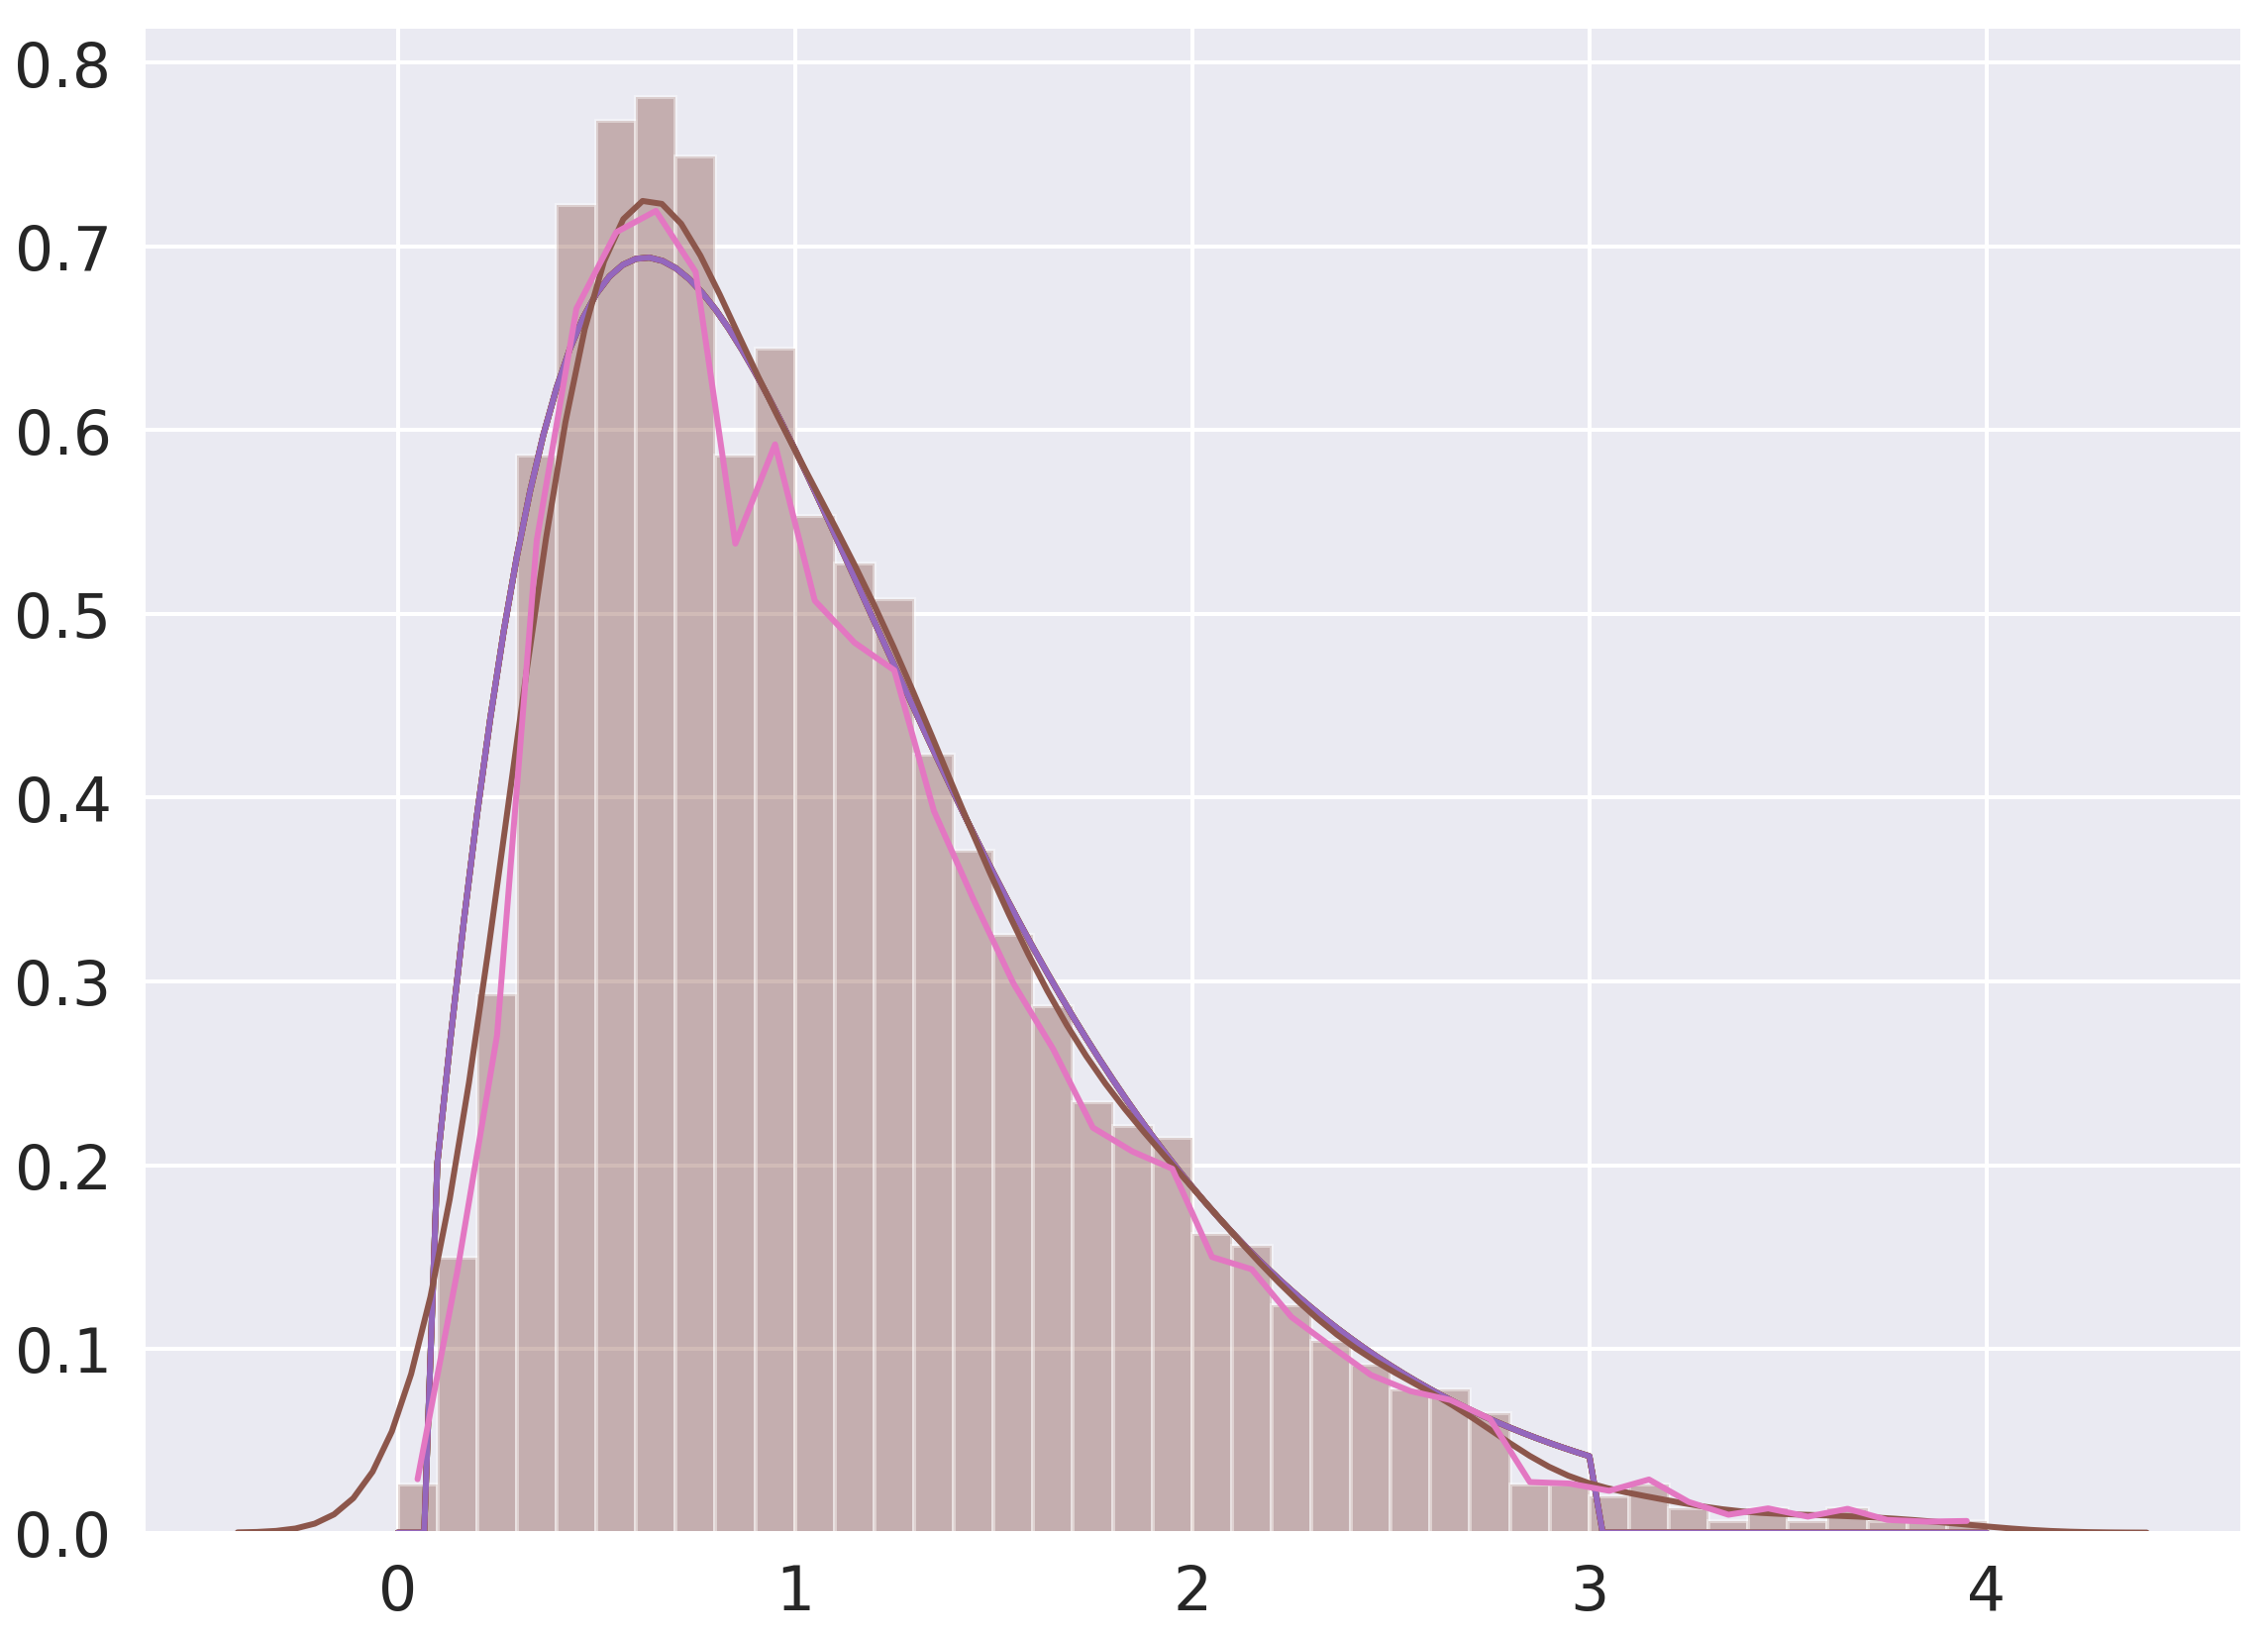

In [21]:
for key in dNdz_dict_source.keys():
    sns.lineplot(z, dNdz_dict_source[key], markers=False)
sns.distplot(datapts, bins=np.linspace(0,4,41));
plt.plot(df['zmid'], df['dneff']/3.5)

In [22]:
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.05*(1+z_s)
    return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
                  * 1/np.sqrt(2*np.pi*sigma_z**2)

pz = ccl.PhotoZFunction(photoz)
z = np.linspace(0, 4, 120)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

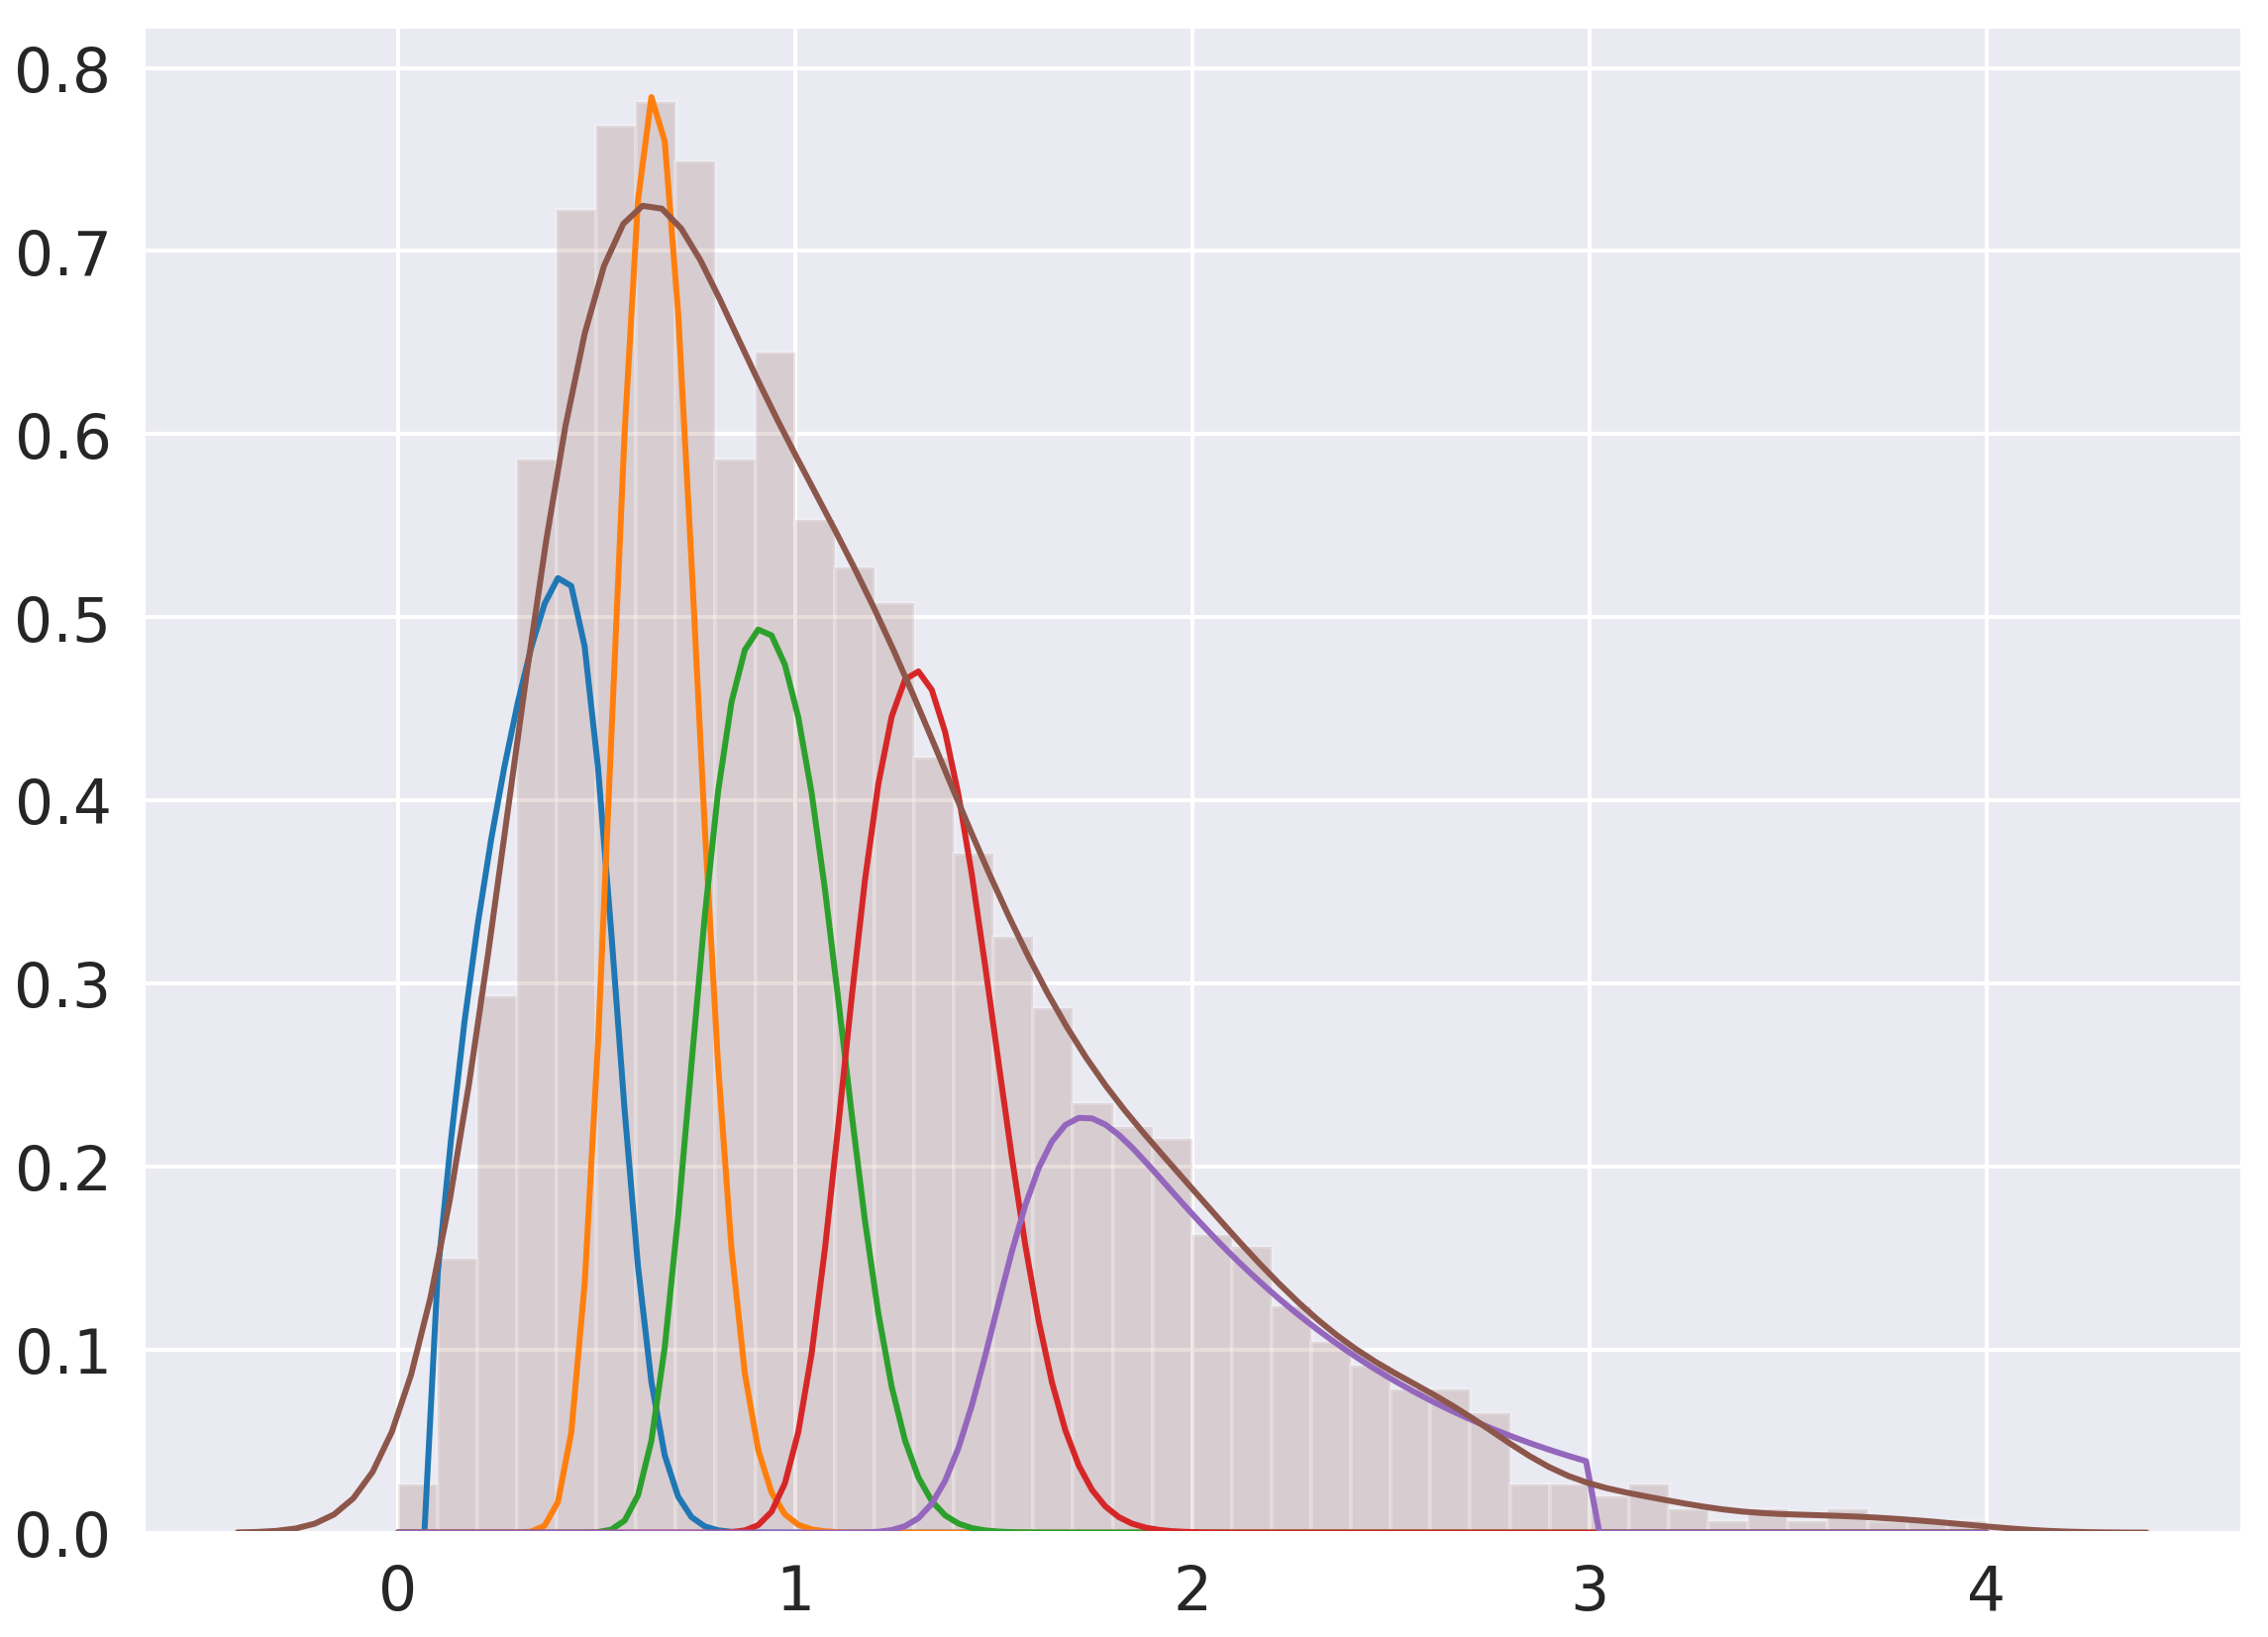

In [23]:
for key in dNdz_dict_source.keys():
    sns.lineplot(z, dNdz_dict_source[key]/5, markers=False)
sns.distplot(datapts, bins=np.linspace(0,4,41), hist_kws=dict(alpha=0.2));

## Lens redshift distribution:

lens sample: 10 redshift bins spaced by 0.1 from 0.2 to 1.2

$$ \frac{dN}{dz} = z^2 exp (- (\frac{z}{z_0})^\alpha) $$
with $$z_0 = 0.28$$ and $$\alpha = 0.9$$
and galaxy bias $$ b(z) = 0.95/G(z)$$ and scatter $$ \sigma_z = 0.03 (1+z) $$

In [24]:
def dNdz_lens(z, alpha=0.9, simga=0.03, zscale=0.28, bias=0.95):
    return  48 * z**2 * np.exp(- (z/zscale)**alpha) 

### Define bins

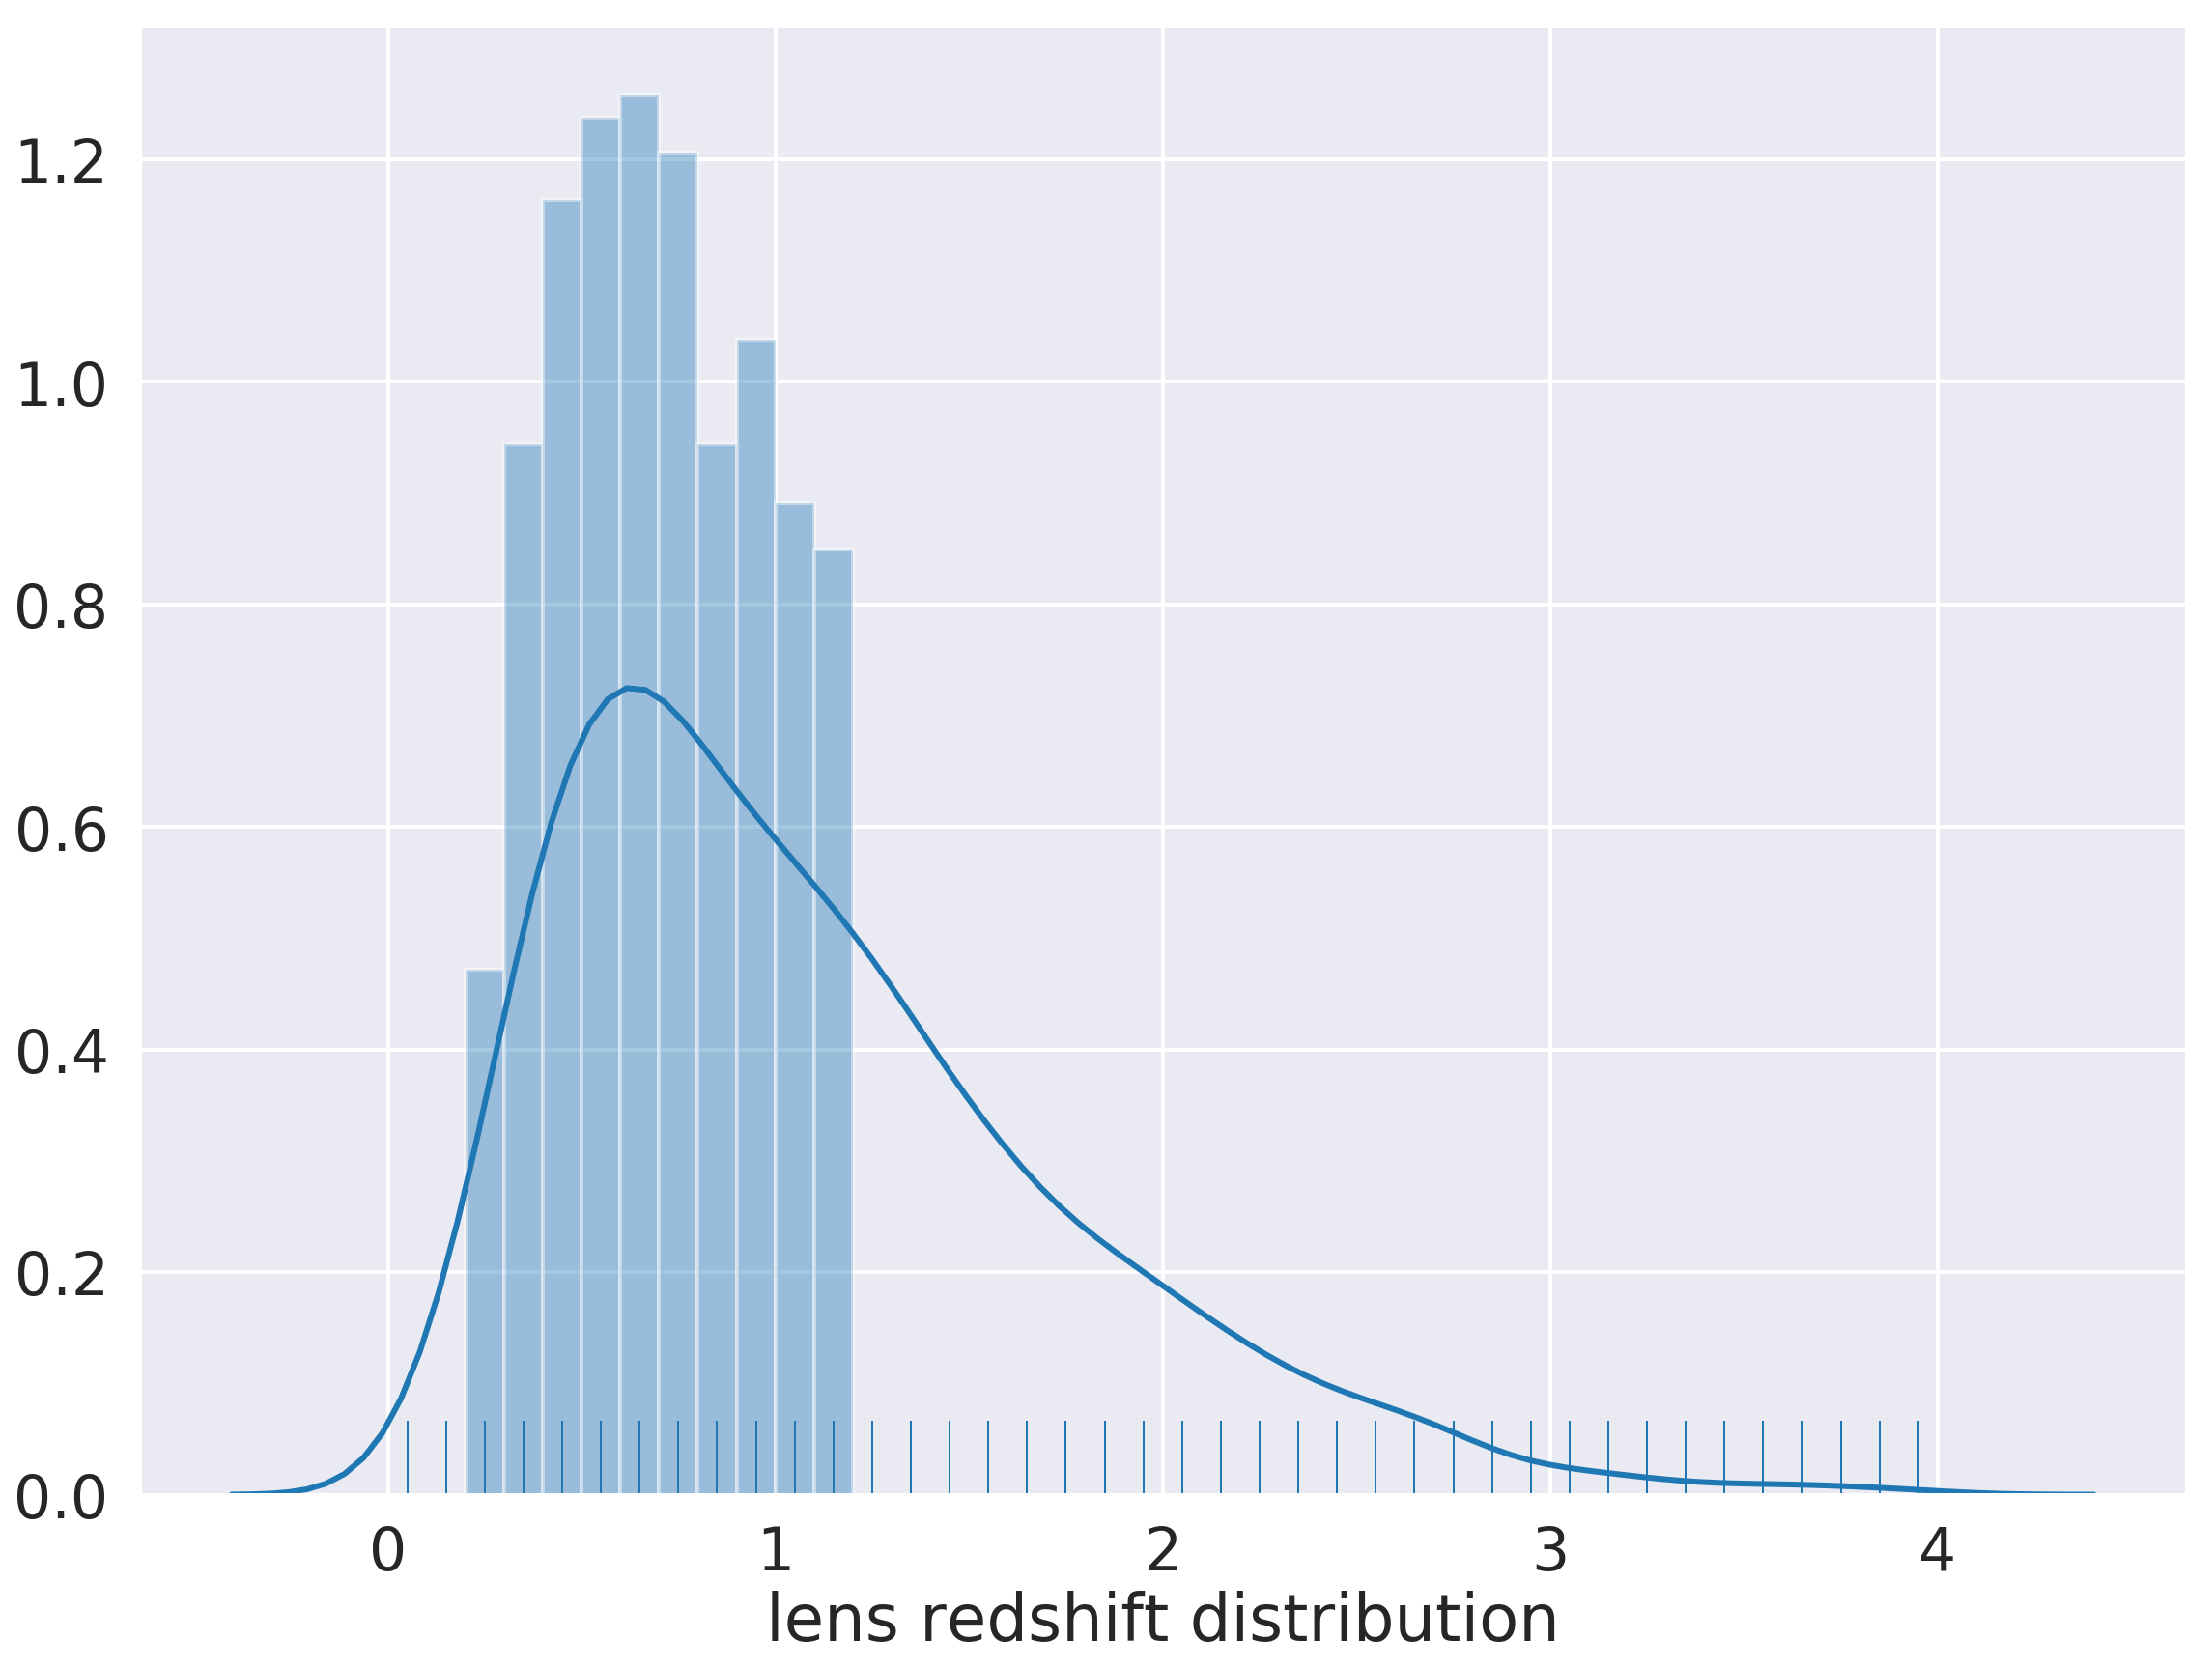

In [25]:
bins = np.linspace(0.2, 1.2, 11) # defines bin edges
z = np.linspace(0,2,21)
bin_centers = [fsum([bin+0.1]) for bin in bins][:-1]
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('lens redshift distribution');

### Creating Lens dN/dz distribution 

In [26]:
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.03*(1+z_s)
    return np.exp(-(z_ph - z_s)**2 / (2*sigma_z**2)) \
            * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz) # creates 0.03 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_lens = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_lens[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)


Text(0,0.5,'n(z)')

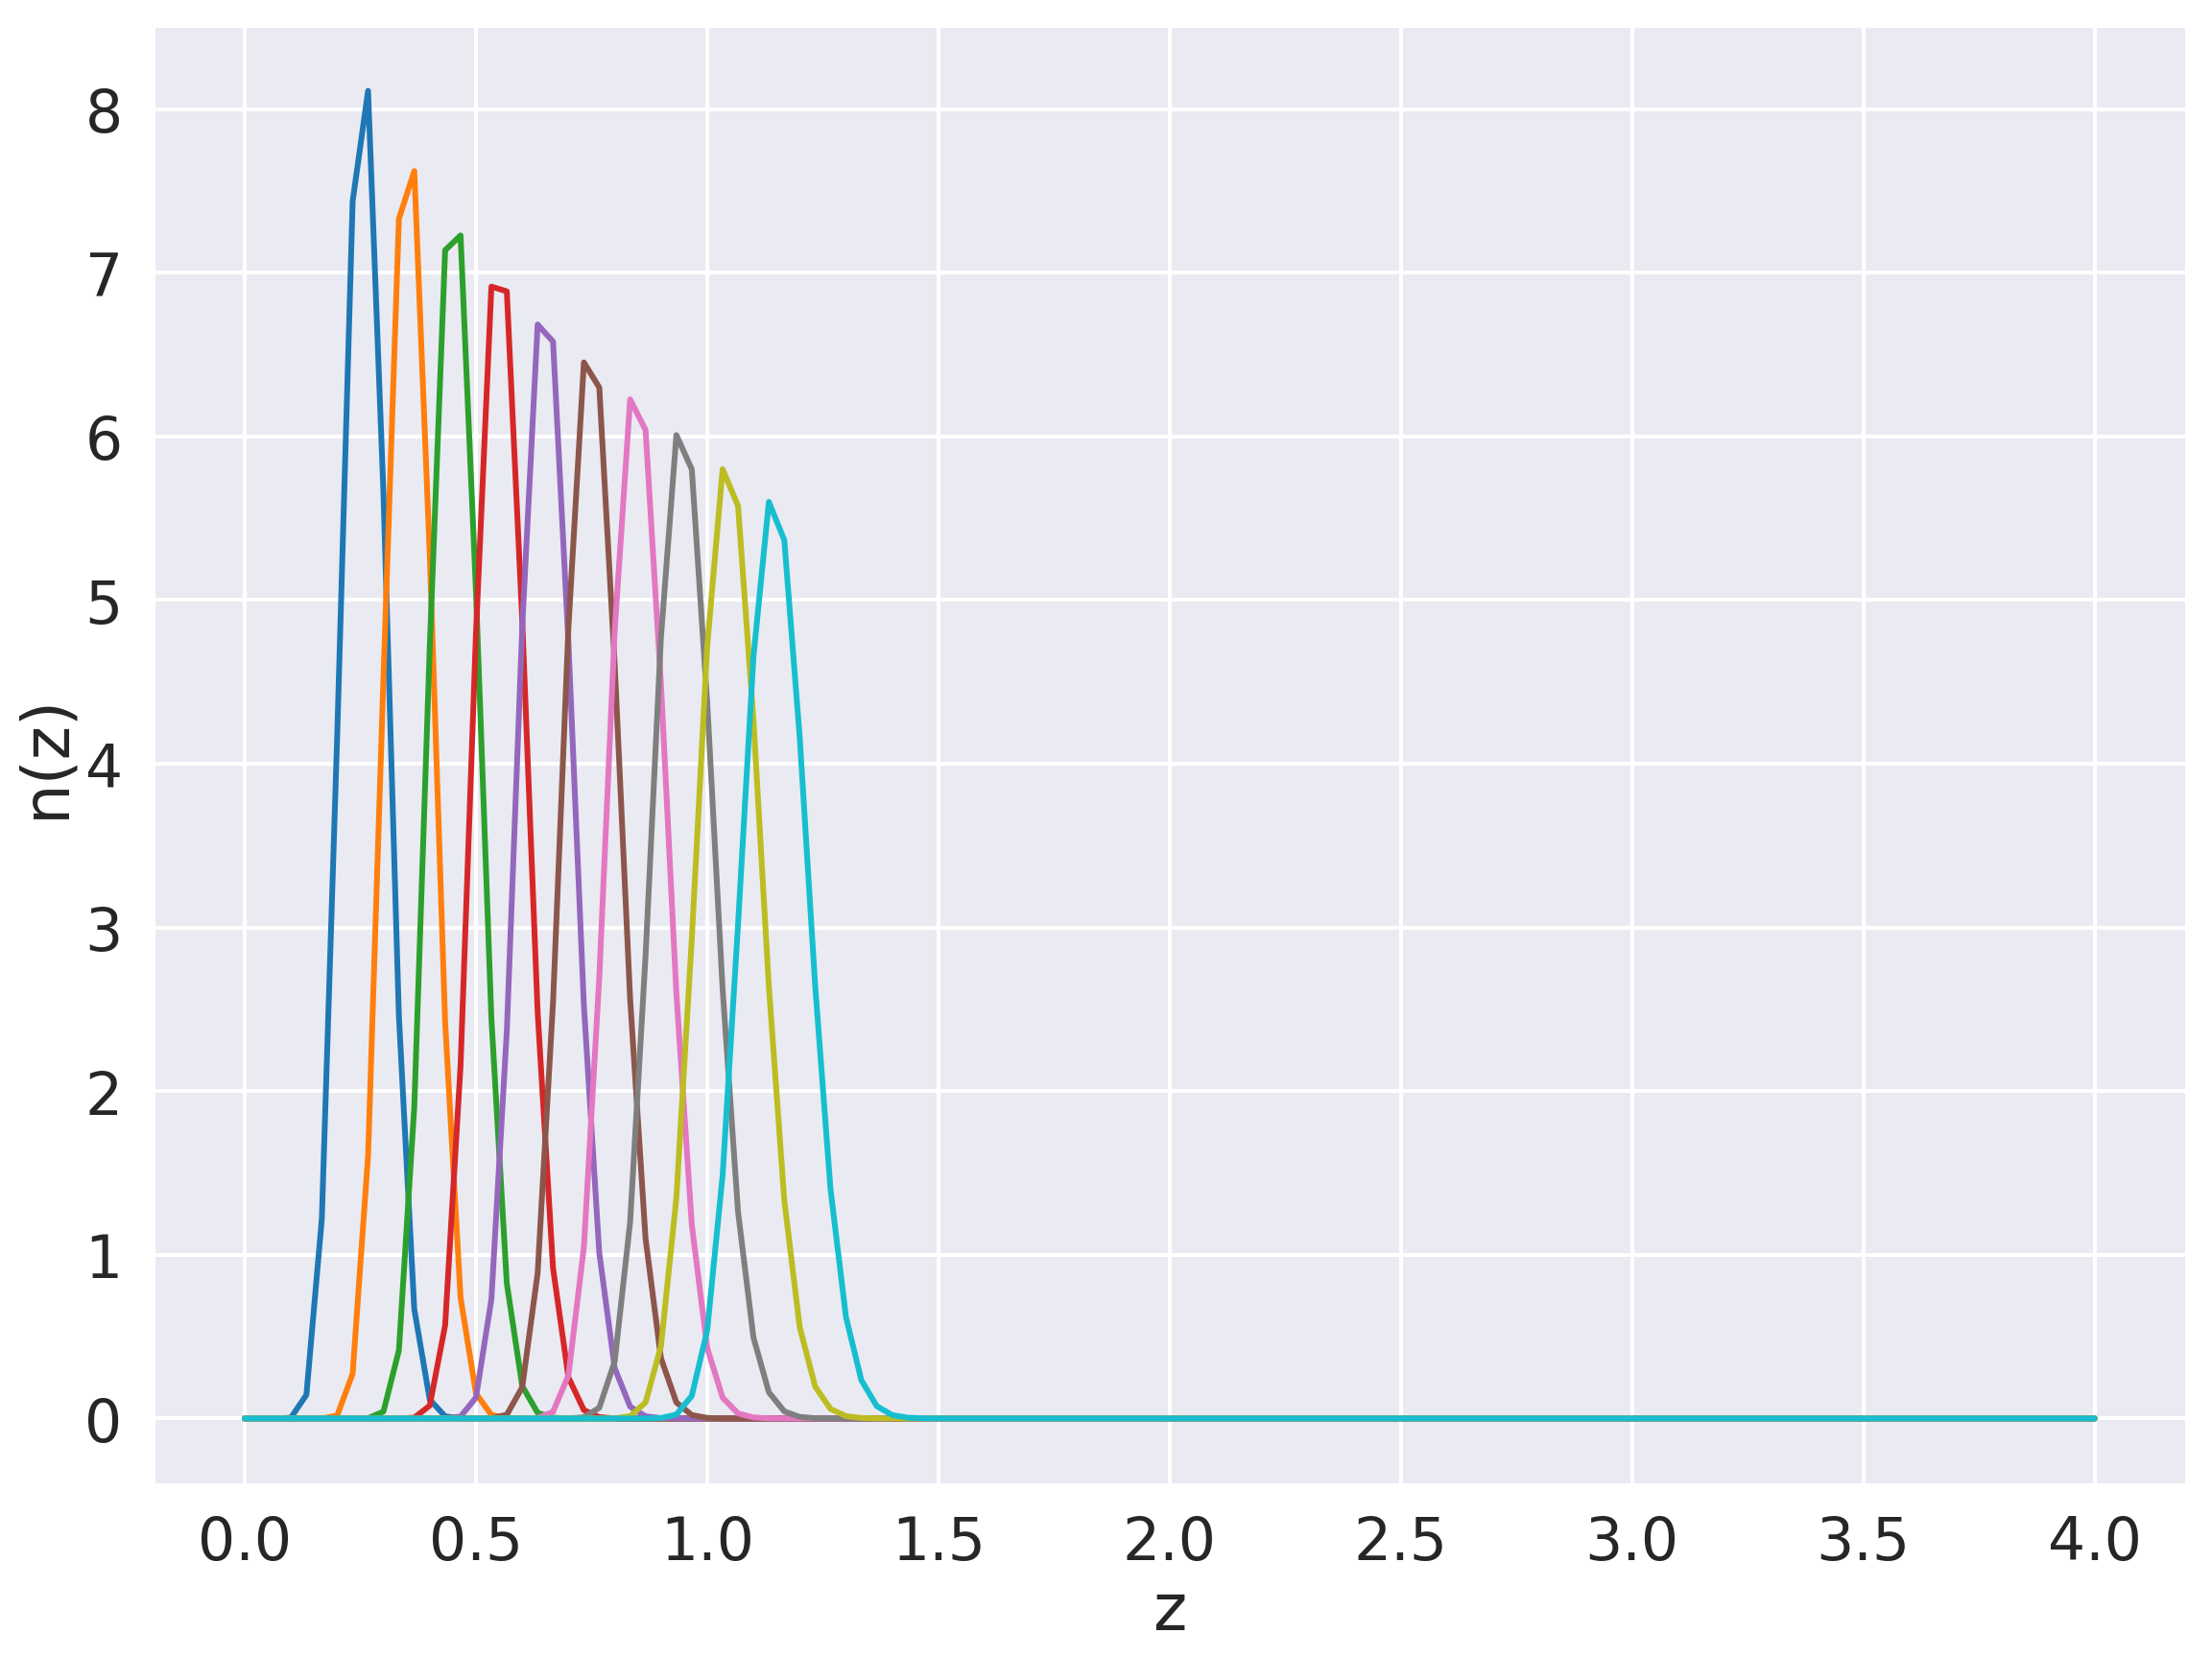

In [27]:
dNdz_lens_df = pd.DataFrame(dNdz_dict_lens)
for key in dNdz_lens_df.columns:
    sns.lineplot(x=z, y=dNdz_lens_df[key], data=dNdz_lens_df, markers=False)
plt.xlabel('z')
plt.ylabel('n(z)')

# Getting correlation functions from CCL

In [28]:
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
pprint(cosmo)

pyccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, n_s=0.9645, sigma8=0.831, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


## Getting shear and clustering tracers

In [50]:
list(ell.to_dict()['ell'].values())

[23.5997,
 32.8594,
 45.75227,
 63.70386,
 88.69901,
 123.5014,
 171.959,
 239.4297,
 333.3735,
 464.1775,
 646.3045,
 899.8917,
 1252.978,
 1744.602,
 2429.1220000000003,
 3382.225,
 4709.291,
 6557.052,
 9129.808,
 12712.02]

In [51]:
ell = pd.read_csv('ell-values', names=['ell'])
ell = list(ell.to_dict()['ell'].values())

In [53]:
ccl_cls = pd.DataFrame()
zbin = 0
j = 0

lst = list(dNdz_dict_source.keys())
for i, key in enumerate(lst):
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    for keyj in lst[i:]:
        lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
        cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
        newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                              'ell': ell,
                              'C_ell': cls})
        ccl_cls = pd.concat((ccl_cls, newdf))
        j += 1
        

ccl_cls = ccl_cls.reset_index()

In [54]:
ccl_cls.head()

,index,C_ell,ell,zbin
0,0,6.757037e-09,23.59970,0
1,1,4.759331e-09,32.85940,0
2,2,3.129444e-09,45.75227,0
3,3,1.933258e-09,63.70386,0
4,4,1.122849e-09,88.69901,0


In [55]:
ccl_cls.describe()

,index,C_ell,ell,zbin
count,300.000000,3.000000e+02,300.000000,300.000000
mean,9.500000,5.186675e-09,2252.517477,7.000000
std,5.775916,1.068979e-08,3413.553209,4.327713
min,0.000000,1.072621e-14,23.599700,0.000000
25%,4.750000,4.888515e-12,114.800803,3.000000
50%,9.500000,2.098050e-10,555.241000,7.000000
75%,14.250000,4.625596e-09,2667.397750,11.000000
max,19.000000,6.656594e-08,12712.020000,14.000000


# the following cell runs all the necessary parts of all the previous cells

In [4]:

df = pd.read_csv('nzdist.txt', sep=' ') 
df.head()
zmid = df['zmid']
dneff = df['dneff']

# turn zmid, dneff pairs into a histogrammable dataset.
datapts = ([list(np.ones(int(dneff[i]/min(dneff)))*zmid[i]) for i in range(len(zmid))])
datapts = list(chain.from_iterable(datapts)) # flatten
bins = datapts[0::int(len(datapts)/5)] # bin edges
bin_centers = [.5*fsum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]
def photoz(z_ph, z_s, args=None):
    # sigma_z = 0.05*(1+z)
    return z_ph
    # return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
    #       * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz)

z = np.linspace(0, 4, 121)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.05*(1+z_s)
    return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
                  * 1/np.sqrt(2*np.pi*sigma_z**2)

pz = ccl.PhotoZFunction(photoz)
z = np.linspace(0, 4, 120)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)
def dNdz_lens(z, alpha=0.9, simga=0.03, zscale=0.28, bias=0.95):
    return  48 * z**2 * np.exp(- (z/zscale)**alpha) 
bins = np.linspace(0.2, 1.2, 11) # defines bin edges
z = np.linspace(0,2,21)
bin_centers = [fsum([bin+0.1]) for bin in bins][:-1]

def photoz(z_ph, z_s, args=None):
    sigma_z = 0.03*(1+z_s)
    return np.exp(-(z_ph - z_s)**2 / (2*sigma_z**2)) \
            * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz) # creates 0.03 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_lens = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_lens[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

dNdz_lens_df = pd.DataFrame(dNdz_dict_lens)

ell = np.linspace(10, 1000, 991)

cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')


ccl_cls = pd.DataFrame()
zbin = 0
j = 0

lst = list(dNdz_dict_source.keys())
for i, key in enumerate(lst):
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    for keyj in lst[i:]:
        lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
        cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
        newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                              'ell': ell,
                              'C_ell': cls})
        ccl_cls = pd.concat((ccl_cls, newdf))
        j += 1
        

ccl_cls = ccl_cls.reset_index()

In [23]:
"""This program predicts the theoretical covariance matrix
for LSS for each row in the input file


USES the cosmosis format

Author: MMRAU
"""

import sys
import numpy as np

 
def get_cov_matrix(l, data_order, cl_vals, orderings, fsky):
    """
    Return the covariance matrix
    Parameters:
    l: mode number
    data_order: order of the data vector
    cl_vals: numpy vector shotnoise already added for lookup purposes
    orderings: bin_ordering of the inputs for lookup purposes
    fsky: sky benefit
    number_density values: shot noise component
    """
    prefac = 1.0/(2.0*l + 1.0)/fsky
    out_cov = np.zeros((len(data_order), len(data_order)))
    for z in range(out_cov.shape[0]):
        for y in range(out_cov.shape[1]):
            i = data_order[z][0]
            j = data_order[z][1]
            k = data_order[y][0]
            l = data_order[y][1]

            try:
                cl_ik = cl_vals[orderings.index([i, k])]
            except ValueError:
                #this happens if only autocorrelation is queried
                cl_ik = 0.0

            try:
                cl_jl = cl_vals[orderings.index([j, l])]
            except ValueError:
                cl_jl = 0.0

            try:
                cl_il = cl_vals[orderings.index([i, l])]
            except ValueError:
                cl_il = 0.0

            try:
                cl_jk = cl_vals[orderings.index([j, k])]
            except ValueError:
                cl_jk = 0.0

            out_cov[z, y] = prefac * (cl_ik*cl_jl + cl_il*cl_jk)
    return out_cov

def multi_bin_cov(fsky, Clbins, Cl_ordering, num_dens): 
        #first column --> l values

    combination_cl = Clbins[:, 0]
    orderings = []
    for i in range(1, Clbins.shape[1]):
        #Cl_orderings has no l entry
        index_comb = Cl_ordering[i-1, :].tolist()
        if index_comb[0] != index_comb[1]:
            #add the entry plus the
            #reversed entry --> would NOT be valid for cross correlations since different
            #bins!!!
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            orderings.append(index_comb)
            orderings.append([index_comb[1], index_comb[0]])
        else:
            #autocorrelations
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            orderings.append(index_comb)

    #remove the first column from combination_cl --> makes it easier since now
    #it corresponds to orderings vector

    combination_cl = combination_cl[:, 1:]

    assert len(orderings) == combination_cl.shape[1]

    #add the shotnoise to each of the cl combinations:
    # TODO: make this an option for clustering vs lensing
    shotnoise = []
    for el in orderings:
        shotnoise.append(1.0/num_dens[int(el[0] - 1)])  # because ordering starts with 1
    shotnoise = np.array(shotnoise)
    assert len(shotnoise) == combination_cl.shape[1]

    for i in range(combination_cl.shape[1]):
        #only the autocorrelation is affected by shot noise
        if orderings[i][0] == orderings[i][1]:
            combination_cl[:, i] += shotnoise[i]

    #now calculate the covariance matrice for each of the Cl_orderings
    out_mat = []
    for i in range(Clbins.shape[0]):
        curr_l = Clbins[i, 0]
        matrix_out = get_cov_matrix(curr_l, Cl_ordering, combination_cl[i, :], orderings, fsky)
        out_mat.append(matrix_out)
    return out_mat
        #np.savetxt(X=matrix_out, fname=out_filename+str(curr_l)+".mat")

def one_bin_cov(fsky, Clbins, num_dens): 
    added_shotnoise = (Clbins[:, 1] + 1.0/num_dens)**2
    prefactor = 2.0/((2.0 * Clbins[:, 0] + 1.)*fsky) 
    covariance = prefactor * added_shotnoise 
    cov_matrix = np.diag(covariance)
    return cov_matrix
    #np.savetxt(X=cov_matrix, fname=out_filename+"onebin.mat")
    



In [24]:
numdens = [2*5.95e7/0.28]*5 
fsky = 0.4

In [25]:
C_ells = []
for i in set(ccl_cls['zbin']):
    C_ells.append(list(ccl_cls[ccl_cls['zbin']==i]['C_ell']))

In [26]:
l = []
for j in range(5):
    l.extend([[j, j+i] for i in range(5-j)])

In [27]:
ordering = np.array(l)

In [28]:
cl_bins= np.vstack((ell, C_ells)).T

In [29]:
cov_matrix_list = multi_bin_cov(fsky, cl_bins, ordering, numdens)

In [30]:
import numdifftools as nd

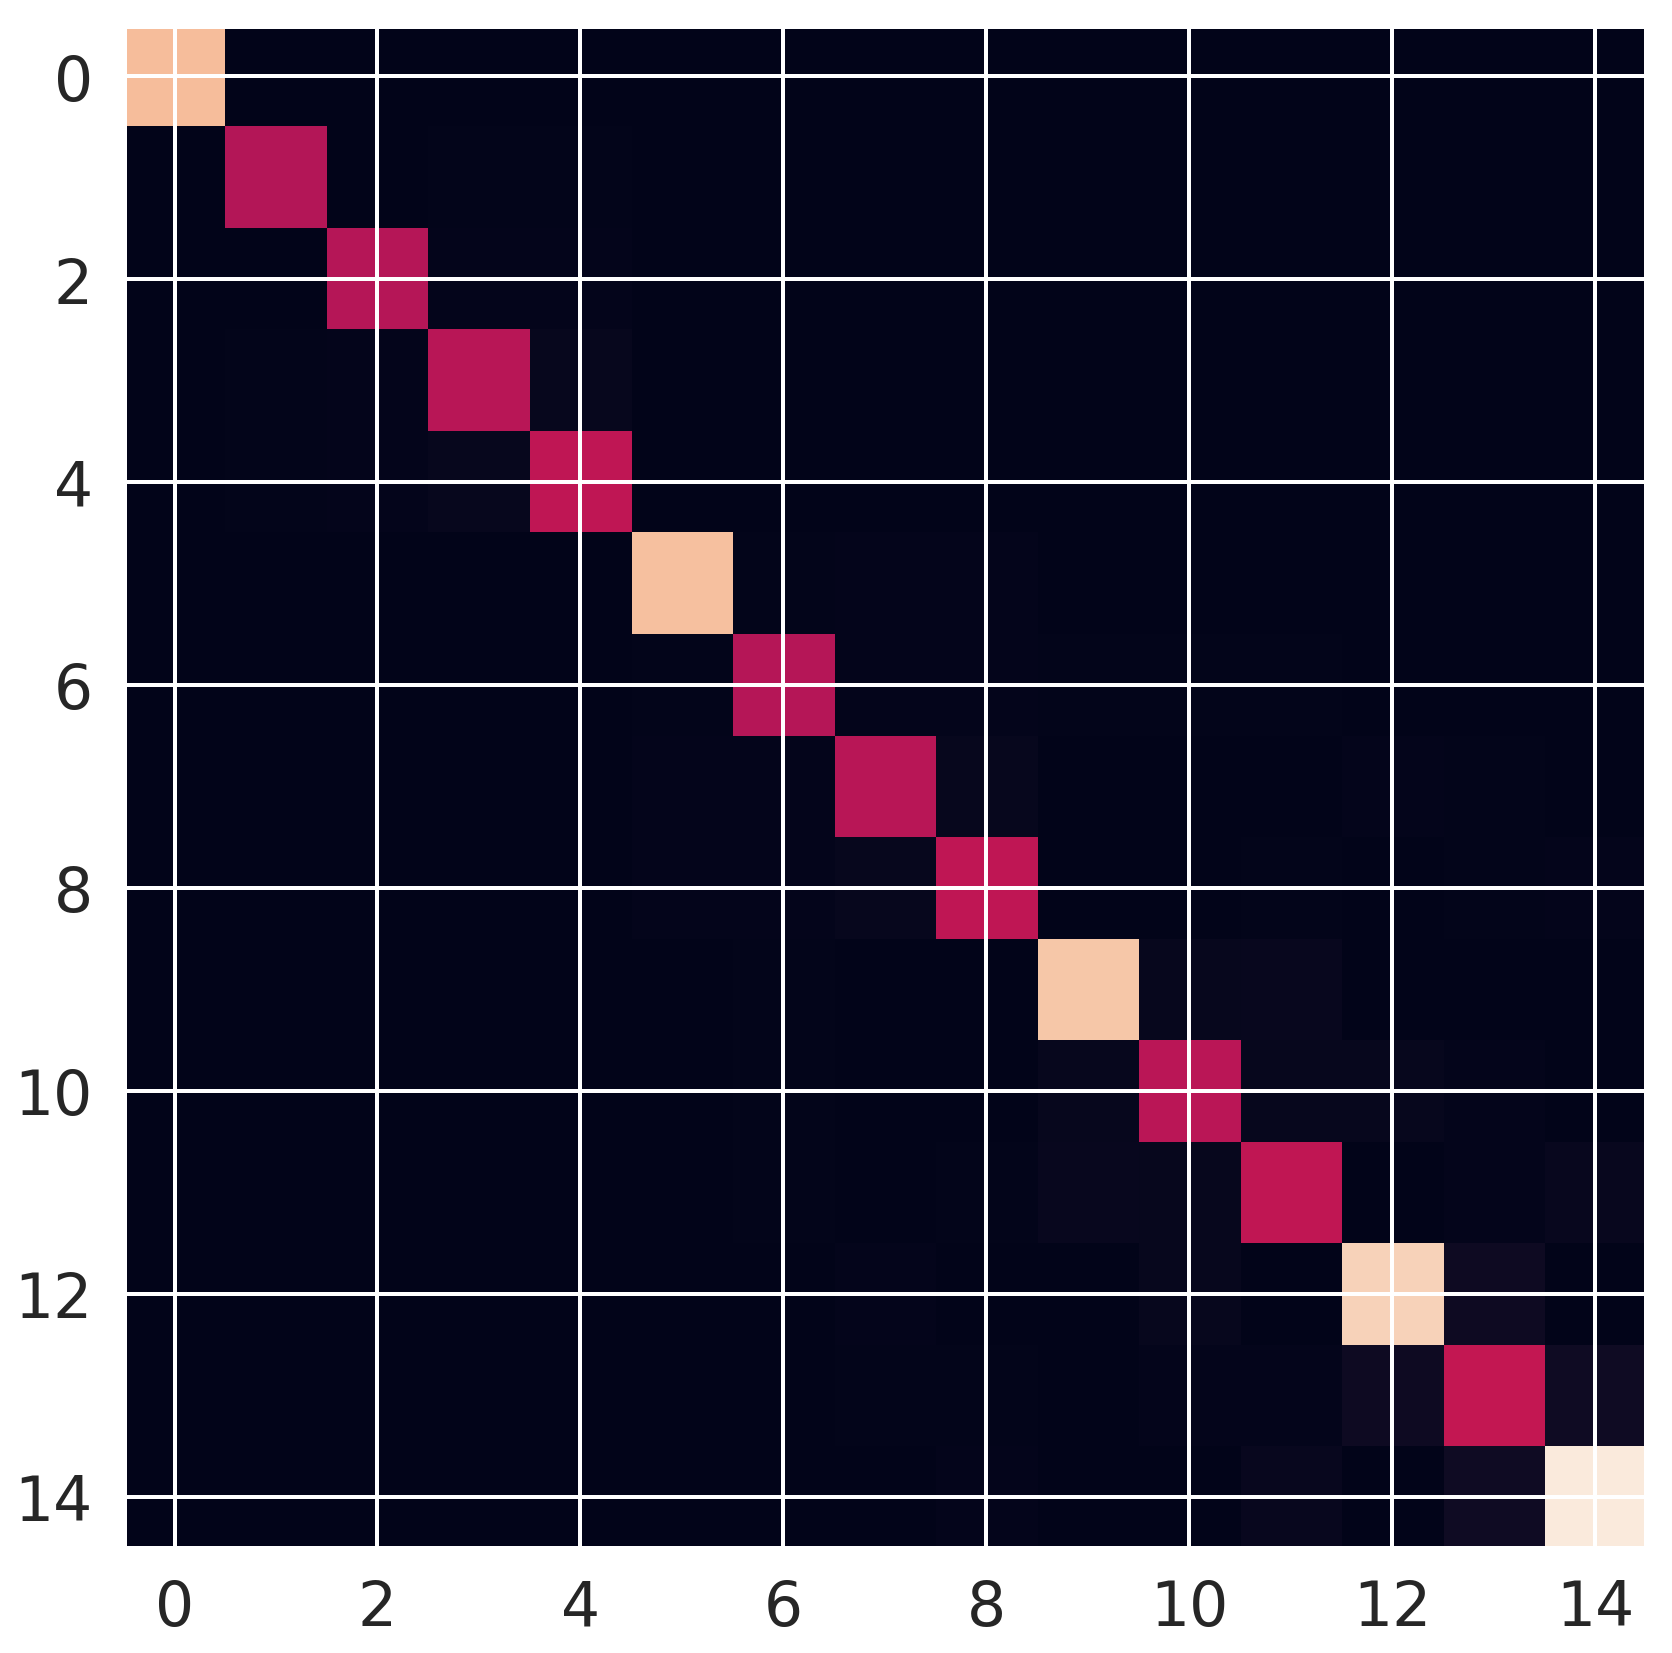

In [246]:
plt.imshow(cov_matrix_list[10])

In [31]:
invcov_list = []
for cov_l in cov_matrix_list:
    invcov_list.append(np.linalg.inv(cov_l))

In [132]:
params = dict(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.381, n_s=0.9645, transfer_function='eisenstein_hu')

In [133]:
ccl.Cosmology(params)

ValueError: Must set either A_s or sigma8 and not both.

In [150]:
list(fid_params.keys())

['Omega_c', 'Omega_b', 'h', 'sigma8', 'n_s', 'wa', 'w0', 'transfer_function']

In [149]:
[param for param in param_order if param not in list(fid_params.keys())]

[]

In [197]:
f = functions[1]

In [32]:
d['Omega_c'](0)

NameError: name 'd' is not defined

In [235]:
d

{}

In [180]:
missing

['h']

In [33]:
from functools import partial

In [ ]:
functions = []

In [282]:
d = {}
param_order = ['Omega_c', 'sigma8', 'n_s', 'w0', 'wa', 'Omega_b']
fid_params = dict(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, wa=0, w0=-1, transfer_function='eisenstein_hu')
functions = []
for param in (param_order):
    new_params = fid_params.copy()
    del new_params[param]
    missing = [param for param in param_order if param not in list(new_params.keys())]
    print(missing)
    def f(param=param, missing=missing):
        print(param)
        print(missing)
        new_params[missing[0]] = param
        print(new_params)
        cosmo = ccl.Cosmology(**new_params)
        return cosmo
    d[param] = partial(f)
    


['Omega_c']
['sigma8']
['n_s']
['w0']
['wa']
['Omega_b']


In [284]:
d['w0'](param=2)

2
['w0']
{'Omega_c': 0.2666, 'h': 0.6727, 'sigma8': 0.831, 'n_s': 0.9645, 'wa': 0, 'w0': 2, 'transfer_function': 'eisenstein_hu'}


ValueError: Necessary parameter 'Omega_b' was not set (or set to None).

In [233]:
d = {}
param_order = ['Omega_c', 'sigma8', 'n_s', 'w0', 'wa', 'Omega_b']
fid_params = dict(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, wa=0, w0=-1, transfer_function='eisenstein_hu')
functions = []
for param in param_order:
    new_params = fid_params.copy()
    del new_params[param]
    missing = [param for param in param_order if param not in list(new_params.keys())]
    def f_factory(i):
        def f(param):
            new_params[missing[0]] = param
            print(new_params)
            cosmo = ccl.Cosmology(**new_params)
            return cosmo
        return f

for i in param_order:           
    f = f_factory(i)
    functions.append(f)

In [222]:
functions[5](1)

pyccl.Cosmology(Omega_c=0.2666, Omega_b=1, h=0.6727, n_s=0.9645, sigma8=0.831, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1, wa=0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [108]:
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')

In [34]:
def getC_ellOfSigma8(sigma8):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=sigma8, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfOmegab(Omega_b):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=Omega_b, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfh(h):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=h, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfn_s(n_s):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=n_s, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfOmegam(Omega_m):
    cosmo = ccl.Cosmology(Omega_c=Omega_m-0.049, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfw0(w_0):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, w0=w_0, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfwa(w_a):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, wa=w_a, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls

In [35]:
funcs = {
    'sigma_8': getC_ellOfSigma8,
    'omega_b': getC_ellOfOmegab,
    'h': getC_ellOfh,
    'n_s': getC_ellOfn_s,
    'omega_m': getC_ellOfOmegam,
    'w_0': getC_ellOfw0,
    'w_a': getC_ellOfwa
}
vals = {
    'sigma_8': 0.831, 
    'omega_b': 0.049, 
    'h': 0.6727, 
    'n_s': 0.9645, 
    'omega_m': 0.3156,
    'w_0': -1,
    'w_a': 0
}

In [36]:
derivs_sig = {}
for var in funcs.keys():
    print(var)
    zbin = 0
    j = 0
    derivs = []
    lst = list(dNdz_dict_source.keys())
    for i, key in enumerate(lst):    
        for keyj in lst[i:]:
            f = nd.Derivative(funcs[var], full_output=True, step=0.01)
            val, info = f(vals[var])

            derivs.append(val)
    derivs_sig[var] = np.array(derivs).T

sigma_8
omega_b
h
n_s
omega_m
w_0
w_a


In [37]:
param_order = ['omega_m', 'sigma_8', 'n_s', 'w_0', 'w_a', 'omega_b', 'h']
fisher = np.zeros((7,7))
for i, var1 in enumerate(param_order):
    for j, var2 in enumerate(param_order):
        f = []
        for l in range(len(derivs_sig[var1])):
            res = derivs_sig[var1][l].T @ invcov_list[l] @ derivs_sig[var2][l]
            f.append(res)
        fisher[i][j] = sum(f)

In [38]:
fisher

array([[ 1.07671402e+06,  5.34579967e+05,  1.67537084e+05,
        -9.44827077e+04, -1.98988774e+04,  6.83005564e+05,
         1.04704177e+05],
       [ 5.34579967e+05,  3.01627235e+05,  6.50625748e+04,
        -4.90269400e+04, -1.10184842e+04,  3.97898271e+05,
         3.77051468e+04],
       [ 1.67537084e+05,  6.50625748e+04,  4.04700401e+04,
        -1.35379440e+04, -2.67531363e+03,  6.65635005e+04,
         2.63602904e+04],
       [-9.44827077e+04, -4.90269400e+04, -1.35379440e+04,
         8.50873737e+03,  1.82792037e+03, -6.38463444e+04,
        -8.25637164e+03],
       [-1.98988774e+04, -1.10184842e+04, -2.67531363e+03,
         1.82792037e+03,  4.14588438e+02, -1.39926689e+04,
        -1.60523286e+03],
       [ 6.83005564e+05,  3.97898271e+05,  6.65635005e+04,
        -6.38463444e+04, -1.39926689e+04,  5.71160944e+05,
         3.38251722e+04],
       [ 1.04704177e+05,  3.77051468e+04,  2.63602904e+04,
        -8.25637164e+03, -1.60523286e+03,  3.38251722e+04,
         1.8127843

In [249]:
invfisher = np.linalg.inv(array([[ 1.65712789e+03,  9.62696034e+02,  1.65879948e+01,
        -1.56171323e+02, -3.03962068e+01,  1.54238894e+03,
         1.18226216e+01],
       [ 9.62696034e+02,  9.17856300e+02, -2.05925403e+02,
        -1.19255677e+02, -2.65013001e+01,  1.82675922e+03,
        -1.99696572e+02],
       [ 1.65879948e+01, -2.05925403e+02,  1.42679379e+02,
         1.58179594e+01,  4.51891218e+00, -5.77431494e+02,
         1.33776218e+02],
       [-1.56171323e+02, -1.19255677e+02,  1.58179594e+01,
         1.72310636e+01,  3.60392397e+00, -2.21136304e+02,
         1.56036662e+01],
       [-3.03962068e+01, -2.65013001e+01,  4.51891218e+00,
         3.60392397e+00,  8.09559129e-01, -4.94884324e+01,
         4.44778751e+00],
       [ 1.54238894e+03,  1.82675922e+03, -5.77431494e+02,
        -2.21136304e+02, -4.94884324e+01,  4.02556894e+03,
        -5.59221800e+02],
       [ 1.18226216e+01, -1.99696572e+02,  1.33776218e+02,
         1.56036662e+01,  4.44778751e+00, -5.59221800e+02,
         1.27378128e+02]]))

In [ ]:
param_order = ['omega_m', 'sigma_8', 'n_s', 'w_0', 'w_a', 'omega_b', 'h']

In [250]:
np.diag(np.sqrt(invfisher))

array([ 1.16461755,  1.98655962,  0.9139533 , 10.78594816, 47.15881177,
        0.28401489,  2.76295904])

In [39]:
def FoM(matrix):
    return np.sqrt(np.linalg.det(matrix))

def plot_contours(matrix, sigmas, fid):
    prefactor = {1:1.52, 2:2.48}
    prefactor = prefactor[sigmas]
    s00, s01, s11 = matrix[0][0], matrix[0][1], matrix[1][1]
    a = np.sqrt(
        0.5*(s00 + s11) + np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b = np.sqrt(
        0.5*(s00 + s11) - np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b *= prefactor
    a *= prefactor
    theta = np.arctan(2*s01/(s00-s11))/2
    el = matplotlib.patches.Ellipse(fid, a/2, b/2, angle=theta)
    return el

def marginalize(fisher_matrix, i, j):
    return np.linalg.inv(np.linalg.inv(fisher_matrix)[np.ix_([i,j], [i,j])]) 

In [7]:
srd_shearshear_fisher = np.array([
 [3.862042e+05, 2.870391e+05, 3.988410e+04, -1.836771e+04, -4.334672e+03, -1.044951e+05, 2.602838e+04, -4.349761e+01, -4.293112e+02, -2.778159e+02, -1.012828e+02]
,[2.870391e+05, 2.256779e+05, 2.201608e+04, -1.454581e+04, -3.599018e+03, -6.133465e+04, 1.531639e+04, -1.863231e+00, -5.156377e+02, -1.923520e+02, -8.753819e+01]
,[3.988410e+04, 2.201608e+04, 1.934393e+04, 9.087428e+01, 3.904829e+01, -3.111333e+04, 8.326912e+03, -2.782530e+01, 1.596846e+02, -2.061966e+01, 1.459089e+00]
,[-1.836771e+04, -1.454581e+04, 9.087428e+01, 1.205082e+03, 2.827191e+02, 2.051291e+03, -4.368172e+02, -1.608722e+00, 5.369081e+01, 1.485670e+01, 6.651976e+00]
,[-4.334672e+03, -3.599018e+03, 3.904829e+01, 2.827191e+02, 7.272162e+01, 4.371019e+02, -9.261110e+01, -7.521380e-01, 1.416361e+01, 3.013875e+00, 1.822204e+00]
,[-1.044951e+05, -6.133465e+04, -3.111333e+04, 2.051291e+03, 4.371019e+02, 1.761669e+05, -1.924990e+04, 4.546274e+01, -1.176277e+02, 8.510893e+01, 1.450646e+01]
,[2.602838e+04, 1.531639e+04, 8.326912e+03, -4.368172e+02, -9.261110e+01, -1.924990e+04, 4.992916e+03, -1.198387e+01, 3.821200e+01, -1.985500e+01, -3.021845e+00]
,[-4.349761e+01, -1.863231e+00, -2.782530e+01, -1.608722e+00, -7.521380e-01, 4.546274e+01, -1.198387e+01, 6.825054e-01, -1.775426e+00, 1.818613e-01, -9.570829e-03]
,[-4.293112e+02, -5.156377e+02, 1.596846e+02, 5.369081e+01, 1.416361e+01, -1.176277e+02, 3.821200e+01, -1.775426e+00, 1.702500e+01, 2.550661e-01, 3.542916e-01]
,[-2.778159e+02, -1.923520e+02, -2.061966e+01, 1.485670e+01, 3.013875e+00, 8.510893e+01, -1.985500e+01, 1.818613e-01, 2.550661e-01, 1.689872e+00, 1.024080e-01]
,[-1.012828e+02, -8.753819e+01, 1.459089e+00, 6.651976e+00, 1.822204e+00, 1.450646e+01, -3.021845e+00, -9.570829e-03, 3.542916e-01, 1.024080e-01, 9.833407e+00]
])

In [40]:
FoM(marginalize(fisher, 3,4))

5.23977190857019

In [42]:
FoM(marginalize(srd_shearshear_fisher[np.ix_([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])], 3,4))

14.162009980909993

In [8]:
def FM_analyze(FM,FM_params):
    n_cosmo = min(7,len(FM_params))
    #print FM
    FMinv= LA.inv(FM)
    covDE=FMinv[np.ix_([3,4],[3,4])]
    # for n in range(0,len(FM_params)):
    #     print("sigma(%s) = %e (no sys: %e, umarg: %e)" % (FM_params[n],np.sqrt(FMinv[n,n]),np.sqrt(FMinv_cosmo[n,n]),1./np.sqrt(FM[n,n])))
    #     print("sigma(%s) = %e (umarg: %e)" % (FM_params[n],np.sqrt(FMinv[n,n]),1./np.sqrt(FM[n,n])))
    ind_w0 = FM_params.index("w0") if "w0" in FM_params else -1 
    ind_wa = FM_params.index("wa") if "wa" in FM_params else -1 
    if ((ind_w0 > -1) & (ind_wa > -1)):
        FOM = 1./np.sqrt(FMinv[ind_w0,ind_w0]*FMinv[ind_wa,ind_wa] -FMinv[ind_w0,ind_wa]*FMinv[ind_wa,ind_w0])
        FOM2 = np.power(LA.det(LA.inv(covDE)),0.5)
        print("FoM = %e %e %d %d" %(FOM,FOM2,ind_wa,ind_w0))
    return FOM

In [9]:
params = ['Omega_m', 'sigma_8', 'n_s', 'w0', 'wa', 'Omega_b', 'h0', 'A', 'beta', 'eta', 'eta_high-z']

In [11]:
from numpy import linalg as LA

In [12]:
FM_analyze(srd_shearshear_fisher, params)

FoM = 1.310743e+01 1.310743e+01 4 3


13.107431925560807



the following numbers are clearly wrong:

In [98]:
inv = np.linalg.inv(srd_shearshear_fisher)

In [101]:
inv[3][4]

-0.0787977752365244

In [103]:
invmarg = np.array([[inv[3][3], inv[3][4]],
                    [inv[4][3], inv[4][4]]])

In [104]:
np.linalg.inv(invmarg)

array([[56.78300973, 13.53783378],
       [13.53783378,  6.25323872]])

In [240]:
import scipy

In [242]:
np.sqrt(np.linalg.det(array([[56.78300973, 13.53783378],
       [13.53783378,  6.25323872]])))

13.107431923411376

In [92]:
wo_wa = marginalize(srd_shearshear_fisher, 3, 4)

In [93]:
wo_wa

array([[56.78300973, 13.53783378],
       [13.53783378,  6.25323872]])

In [95]:
FoM(wo_wa, 1)

0.03302137956715151

In [84]:
FoM(marginalize(fisher, 3, 4), 1)

99.56408556658096